In [138]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import torchvision.utils as vutils

In [139]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [140]:
num_epochs = 1
batch_size = 4
batches = 900/batch_size

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224, scale=(0.7,1), ratio=(0.9,1.1)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'chihuahuamuffin'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

original_dataset = datasets.ImageFolder(os.path.join(data_dir, 'original'), data_transforms['val'])
original_dataloader = torch.utils.data.DataLoader(original_dataset, batch_size=16, shuffle=False)

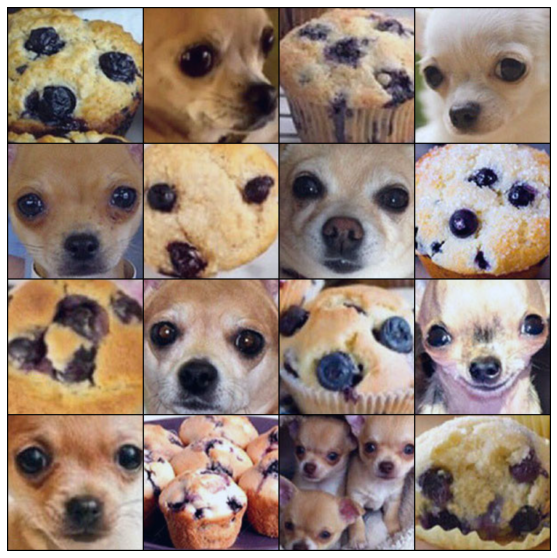

In [141]:
# Some pictures from the dataset
batch = next(iter(original_dataloader))[0].to(device)
plt.figure(figsize=(10,10))
plt.axis("off")
plt.imshow(np.transpose(vutils.make_grid(batch, nrow= 4, padding=2, normalize=True).cpu(),(1,2,0)))

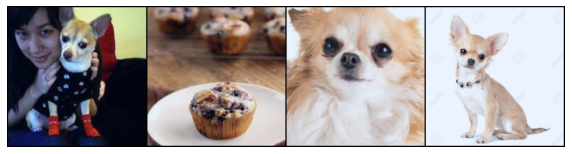

In [142]:
# Some pictures from the dataset
real_batch = next(iter(dataloaders['train']))
plt.figure(figsize=(10,10))
plt.axis("off")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:36], nrow= 6, padding=2, normalize=True).cpu(),(1,2,0)))

In [5]:
model = torchvision.models.resnet18(pretrained=True)
for param in model.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)

model = model.to(device)

loss = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer = optim.SGD(model.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [6]:
for epoch in range(num_epochs):
    print("epoch:", epoch, "/", num_epochs)

    for phase in ['train', 'val']:
        if phase == 'train':
            model.train()
        else:
            model.eval()

        running_loss = 0.0
        running_corrects = 0

        for i, (inputs, labels) in enumerate(dataloaders[phase]):
            if phase == 'train':
                print("{:.0f}%".format(i*100/batches), end="\r")
            
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                batch_loss = loss(outputs, labels)
                
                if phase == 'train':
                    batch_loss.backward()
                    optimizer.step()

            running_loss += batch_loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
                
        if phase == 'train':
            scheduler.step()

        epoch_loss = running_loss / dataset_sizes[phase]
        epoch_acc = running_corrects.double() / dataset_sizes[phase]

        print(f'{phase} - Loss: {epoch_loss:.4f} Accuracy: {epoch_acc:.4f}')

epoch: 0 / 1
train - Loss: 0.2635 Accuracy: 0.8767
val - Loss: 0.0066 Accuracy: 1.0000


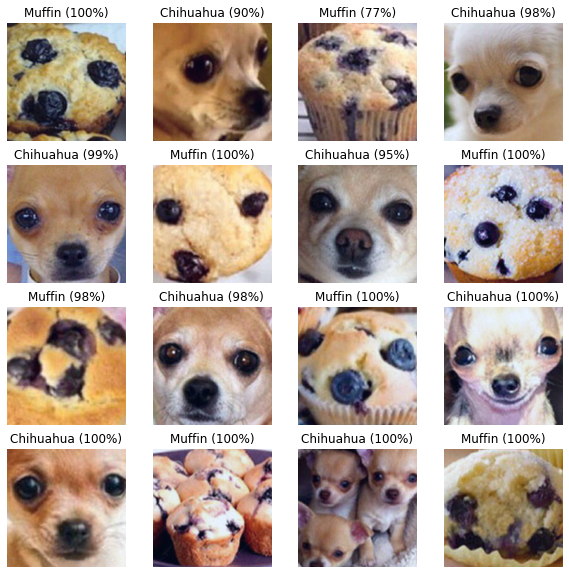

In [145]:

f = plt.figure(figsize=(10,10))
for i in range(inputs.size()[0]):
    ax = f.add_subplot(4, 4, i+1)
    ax.axis('off')
    result = model(batch[i:i+1])[0]
    c =  exp(result[0])
    m =  exp(result[1])
    if c>m:  
        ax.set_title("Chihuahua ({:.0f}%)".format(100*c/(c+m)))
    else:
        ax.set_title("Muffin ({:.0f}%)".format(100*m/(c+m)))
    plt.imshow(np.transpose(vutils.make_grid(batch[i:i+1], nrow= 4, padding=2, normalize=True).cpu(),(1,2,0)))